<a href="https://colab.research.google.com/github/ShinAsakawa/bit/blob/main/notebooks/2022_0611bit_faster_rcnn_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
- date: 2022_0604 original file written at 2022_0319
- filename: 2022_0604bit_faster-rcnn_fine_tuning.ipynb
- ref source: https://www.kaggle.com/yerramvarun/fine-tuning-faster-rcnn-using-pytorch/notebook
---

**注**: workers=0 で動作するので時間がかかる

# faster-rcnn 転移学習または微調整を用いた BIT 線分 2 等分課題

[BIT] 図版を [Faster RCNN](https://arxiv.org/abs/1506.01497) で微調整して訓練

* Faster RCNNについては [Faster-RCNNの仕組みをより深く理解するために](https://medium.com/@whatdhack/a-deeper-look-how-faster-rcnn-works-84081284e1cd) の Media 参照。
* [Pytorch 公式チュートリアル文書](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) も参照

転移学習 transfer learning と微調整 fine tuning については，種々考え方がある。
だがここでは，[PyTorch のチュートリアル](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html) に従って，
最終層だけ入れ替えて，最終直下層以下の結合係数を固定して考える場合を転移学習と呼ぶことにする。
全層を再学習することを，微調整と呼ぶことにする。
このチュートリアルが参照にしているのは，Karpathy の スタンフォードでの授業 [cs231n の転移学習のノート](https://cs231n.github.io/transfer-learning/) である。


<center>
<img src="https://github.com/ShinAsakawa/bit/blob/main/notebooks/figures/R_CNN.png?raw=1" width="66%"><br/>
<img src="https://miro.medium.com/max/1400/1*1Mj0C4wzi57Z6Z933gb6vA.png" width="66%"><br/>
<div style="backgournd-color:cornsilk;width:66%;text-align:left">

図 Faster-RCNN のブロック図 <!-- Fig 1: Faster-RCNN block diagram.  -->
赤紫色のブロックは訓練時のみ活性化<!--The magenta colored blocks are active only during training. -->
数値はテンソルサイズ<!--The numbers indicate size of the tensors.-->
画像出典: Goswami [A deeper look at how Faster-RCNN works](https://whatdhack.medium.com/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd)
<!-- source: Subrata Goswami [A deeper look at how Faster-RCNN works](https://whatdhack.medium.com/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd)-->
</div>  </center>


<!-- <div class="fig">
<img src="figures/2020Beery_fig3.svg" width="88%"><br/>
Beery et al. (2020) Fig. 3, `Context R-CNN: Long Term Temporal Context for Per-Camera Object Detection`, arXiv:1912.03538
</div> -->


# 1. インストールとインポート
<!-- ## Installs and Imports -->

## 1.1 下準備

必要なライブラリのインストールなど

In [1]:
# 2022_0605 現在，下記の再インストールが必要のようだ
# また，訓練時に halt する
!pip install --upgrade albumentations
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 5.2 MB/s 
     |████████████████████████████████| 48.3 MB 1.2 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
Found existing installation: opencv-python-headless 4.6.0.66
Uninstalling opencv-python-headless-4.6.0.66:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.6.0.66.dist-info/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavcodec-5896f664.so.58.134.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavformat-8ef5c7db.so.58.76.100
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless.libs/libavutil-9c768859.so.56.70.100
    /usr/local/lib/python3.

In [ ]:
import os
import sys
import shutil
import typing
import cv2
import glob
from tqdm.notebook import tqdm

import IPython
isColab = 'google.colab' in str(IPython.get_ipython())

if isColab:
    from PIL import ImageFont
    from glob import glob

    !pip install pycocotools --quiet
    !git clone https://github.com/pytorch/vision.git
    !git checkout v0.3.0

    # Download TorchVision repo to use some files from references/detection
    # os.symlink(src,dst) にした方が良いかも
    !cp vision/references/detection/utils.py ./
    !cp vision/references/detection/transforms.py ./
    !cp vision/references/detection/coco_eval.py ./
    !cp vision/references/detection/engine.py ./
    !cp vision/references/detection/coco_utils.py ./
    
    !pip install japanize_matplotlib
    #!pip install albumentataions  # 2022_0604 一時的に中断 colab でエラー発生のため
    
    # 自作ライブラリ
    !git clone https://github.com/ShinAsakawa/bit.git

    # Noto fonts のダウンローAドとインストール
    !mkdir Noto_JP_fonts
    !wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifJP.zip
    !wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansJP.zip
    !unzip NotoSerifJP.zip -d Noto_JP_fonts
    !unzip -o NotoSansJP.zip -d Noto_JP_fonts  # `-o` means overwrite 
    !mv Noto_JP_fonts bit
    !mkdir data
    
    noto_font_dir = './bit/Noto_JP_fonts'
    notofonts_fnames = glob(os.path.join(noto_font_dir,'*otf'))
    notofonts = {fname.split('/')[-1].split('.')[0]:{'fname':fname} for fname in notofonts_fnames}
    for fontname in notofonts.keys():
        notofonts[fontname]['data'] = ImageFont.truetype(notofonts[fontname]['fname'])
else:
    # 自分のリポジトリからシンボリックリンクで代用
    for file in ['engine.py', 'utils.py', 'coco_utils.py', 'transforms.py', 'coco_eval.py']:
        if not os.path.exists(file):
            _file = os.path.join('../2020pytorch_vision.git/reference/detection/', file)
            !ln -s ../2020pytorch_vision.git/references/detection/engine.py .
            !ln -s ../2020pytorch_vision.git/references/detection/utils.py .
            !ln -s ../2020pytorch_vision.git/references/detection/coco_utils.py .
            !ln -s ../2020pytorch_vision.git/references/detection/transforms.py .
            !ln -s ../2020pytorch_vision.git/references/detection/coco_eval.py .
            
            
# https://github.com/amikelive/coco-labels を参考に日本語訳したもの 全 91 種類
CLASSES = [
    '背景',                                                       # 0
    '人', '自転車', '車', 'バイク', '飛行機',                        # [01-05]
    'バス', '電車', 'トラック','ボート', '信号機',                    # [06-10]
    '消火栓', '道路標識', '停止サイン', 'パーキングメーター', 'ベンチ',   # [11-15]
    '鳥', '猫', '犬', '馬', '羊',                                   # [16-20]
    '牛', 'ゾウ', '熊',  'シマウマ', 'キリン',                        # [21-25]
    '帽子', 'リュックサック', '傘', '靴', 'メガネ',                    # [26-30]
    'ハンドバッグ',  'ネクタイ', 'スーツケース', 'フリスビー', 'スキー',   # [31-35
    'スノーボード','スポーツボール','凧', '野球バット', '野球グローブ',    # [36-40]
    'スケートボード', 'サーフボード', 'テニスラケット', 'ボトル', '皿',    # [41-45]
     'ワイングラス', 'カップ', 'フォーク', 'ナイフ', 'スプーン',          # [46-50]
    'ボウル', 'バナナ', 'りんご', 'サンドイッチ', 'オレンジ',            # [51-55]
    'ブロッコリー', 'ニンジン', 'ホットドッグ', 'ピザ', 'ドーナツ',      # [56-60]
    'ケーキ', '椅子', 'ソファ', '鉢植え', 'ベッド',                   # [51-65]
    '鏡', 'ダイニングテーブル', '窓', 'デスク', 'トイレ',              # [66-70]
    'ドア', 'テレビ', 'ノートパソコン', 'マウス', 'リモコン',          # [71-75]
    'キーボード',  '携帯電話', '電子レンジ', 'コンロ', 'トースター',    # [76-80]
    '洗面台', '冷蔵庫', 'ミキサー', '本', '時計',                    # [81-85]
    '花瓶', 'ハサミ', 'テディベア', 'ドライヤー', '歯ブラシ']          # [85-90]

# DETR のサンプルプログラムを借用
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS = COLORS * 100

## 1.2 ライブラリのインポート

In [7]:
# ライブラリのインポート
# python と機械学習のための基本ライブラリ
import os
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import japanize_matplotlib

# torchvision ライブラリ
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn
# torchvision.models.detection.retinanet_resnet50_fpn` で RetinaNet を使用してみることもできる。
# SSDlite なら `torchvision.models.detection.ssdlite320_mobilenet_v3_large`
# SSD は `torchvision.models.detection.ssd300_vgg16` を用いる
# これらモデルの詳細については `https://pytorch.org/vision/stable/auto_examples/plot_visualization_utils.html#instance-seg-output`

# ヘルパライブラリをインポート
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# #画像のデータ拡張 当面は不要
# だが `get_transform()` で 用いているため試しに使ってみる
# import albumentations as A
# from albumentations.pytorch.transforms import ToTensorV2

# 2. データセットの作成

## 2.1 自作ライブラリの読み込み，下請け関数の定義

In [8]:
%load_ext autoreload
%autoreload 2
from bit import BIT

if isColab:
    bit = BIT(fontdata=notofonts)
else:
    bit = BIT()
images, bboxes = bit.make_line_bisection_task_images(N=1, n_lines=3)

#print(f'bboxes:{bboxes[0]}, len(bboxes):{len(bboxes[0])}')

import PIL
def plot_pilimg_and_bbox(pil_img:PIL.Image.Image, 
                         bboxes:list,
                         verbose:bool=False
                        ):
    """bounding box (物体を囲む四角形の境界領域のことを境界領域箱と呼ぶ): bbox
    PIL 画像を境界領域と共に表示する関数"""
    plt.figure(figsize=(10,8))
    plt.imshow(pil_img)
    ax = plt.gca()
    for (xmin, ymin, xmax, ymax), c in zip(bboxes, COLORS):
        if verbose:
            print(f'xmin:{xmin}, ymin:{ymin}')
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=2))    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2.2. 線分二等分線用画像の作成と書き出し

In [9]:
%%time
# 訓練データセット，テストデータセットの作成

#lines = [3]
lines = [3,4,5]                # 一枚の刺激画像に何本の水平線が含まれるか
#lines = [3,4,5,6]               # 一枚の刺激画像に何本の水平線が含まれるか
#lines = [3,6]                   # 一枚の刺激画像に何本の水平線が含まれるか
train_dups, test_dups = 10, 5  # 各条件ごとに何枚画像を生成するか
#train_dups, test_dups = 25, 5  # 各条件ごとに何枚画像を生成するか
#train_dups, test_dups = 5, 1    # 各条件ごとに何枚画像を生成するか
train_bboxes, test_bboxes = [], []
train_imgs, test_imgs = [], []

# 訓練画像データ用ディレクトリが存在しなければ作成する
if not os.path.exists('./data/2022bit_line_bisection'):
    os.mkdir('./data/2022bit_line_bisection')
train_dirname = './data/2022bit_line_bisection/train'
test_dirname = './data/2022bit_line_bisection/test'
if os.path.exists(train_dirname):
    shutil.rmtree(train_dirname)
if os.path.exists(test_dirname):
    shutil.rmtree(test_dirname)

for dir_name in [train_dirname, test_dirname]:
    if not os.path.exists(dir_name):
        os.mkdir(dir_name) 
        
for line in lines:
    images, bboxes = bit.make_line_bisection_task_images(N=train_dups, n_lines=line)
    train_imgs += images
    train_bboxes += bboxes
    images, bboxes = bit.make_line_bisection_task_images(N=test_dups, n_lines=line)
    test_imgs += images
    test_bboxes += bboxes

# 訓練データセットの書き出し
for i, img in enumerate(train_imgs):
    stim_fname = f'{i:04d}.png'
    stim_fname = os.path.join(train_dirname, stim_fname)
    with open(stim_fname, 'wb') as fp:
        img.save(fp,format='png')

with open(os.path.join(train_dirname,'bboxes.txt'),'w') as fp:
    for bbox in train_bboxes:
        fp.write(str(bbox)+'\n')
            
# 検証データセットの書き出し
for i, img in enumerate(test_imgs):
    stim_fname = f'{i:04d}.png'
    stim_fname = os.path.join(test_dirname, stim_fname)
    with open(stim_fname, 'wb') as fp:
        img.save(fp,format='png')

with open(os.path.join(test_dirname,'bboxes.txt'),'w') as fp:
    for bbox in test_bboxes:
        fp.write(str(bbox)+'\n')

CPU times: user 19.2 s, sys: 267 ms, total: 19.4 s
Wall time: 19.3 s


## 2.3 線分二等分線課題作成用データ作成クラスの定義

In [11]:
from torchvision.transforms import functional as F
# import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_transform():
    
    return A.Compose([
        # ToTensorV2 converts image to pytorch tensor without div by 255
        ToTensorV2(p=1.0) 
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})


class BIT_LineBisection(torch.utils.data.Dataset):
    """留意事項
    1. データセットはタプルを返す。1 つ目の要素は画像の形状，2 つ目の要素は辞書である。
    2. 画像はデータセット定義時に指定したサイズでカラーモードは RGB
    3. 画像には 4 つのバウンディングボックスがあり，これはボックス内の 4 つのリストとラベルの長さから明らかである。
    """
    def __init__(self, dirname='data/2022bit_line_bisection/train',
                 transforms=get_transform):
        
        self.transforms = transforms
        self.dirname = dirname
        self.data_fnames = sorted(glob(os.path.join(dirname,'*.png')))
        #self.data_fnames = sorted(glob.glob(os.path.join(dirname,'*.png')))
        self.n_data = len(self.data_fnames)

        # 武藤先生から送信された画像は 4662 X 3289 なので，この縮尺因子で画像も境界ボックスも規格化する
        muto_width = 4662
        muto_height = 3289
        self.height = 224
        self.width = 224
        self.height_f = 224 / muto_height
        self.width_f =  224 / muto_width
        #self.height_f *= int(muto_height / muto_width)
        
        # 境界領域ボックス (左,上,右,下) 4 点からなるデータを `bboxes.txt` から読み込む
        bboxes_fname = os.path.join(self.dirname, 'bboxes.txt')
        with open(bboxes_fname, 'r') as fp:
            X = fp.readlines()
        self.bboxes = {}
        for i, line in enumerate(X):
            digs = np.array([int(d) for d in line.strip().replace('[','').replace(']','').split(',')])
            self.bboxes[i] = np.reshape(digs,((-1,4)))
            
            for box in self.bboxes[i]:
                box[0] *= self.width_f
                box[1] *= self.height_f
                box[2] *= self.width_f
                box[3] *= self.height_f
            
    def __getitem__(self, index):
        #img = plt.imread(self.data_fnames[index])
        #img = torch.Tensor(img).permute(2,0,1)
        
        # reading the images and converting them to correct size and color    
        img = cv2.imread(self.data_fnames[index])
        #img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        img = img_res
        img = torch.Tensor(img).permute(2,0,1)
        
        # convert boxes into a torch.Tensor
        bboxes = torch.as_tensor(self.bboxes[index], dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        
         # suppose all instances are not crowd
        iscrowd = torch.zeros((bboxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor([bit.symbols.index('<line>') for _ in range(self.bboxes[index].shape[0])], dtype=torch.int64)
        #labels = torch.as_tensor([bit.symbols.index('<line>') for _ in range(train_dataset.bboxes[index].shape[0])], dtype=torch.int64)

        target = {}
        target["boxes"] = bboxes
        #target["labels"] = labels.unsqueeze(0)
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd

        # image_id
        image_id = torch.tensor([index])
        target["image_id"] = image_id        
        
        #transformed = self.transforms(image = img,
        #                              bboxes = target['boxes'],
        #                              labels = labels)
        #img = transformed['image']
        
        return img, target
        #return img, self.bboxes[index]
        #return self.data_fnames[index], self.bboxes[index]

        
    def __len__(self):
        return self.n_data
            
train_dataset = BIT_LineBisection()
test_dataset = BIT_LineBisection(dirname='data/2022bit_line_bisection/test')

## 2.4. 作成した画像データを視覚化して例示

N:10 target:{'boxes': tensor([[ 23.,  65., 186.,  73.],
        [ 29.,  97., 191., 106.],
        [ 21., 131., 184., 140.],
        [ 21., 162., 183., 172.],
        [ 28., 189., 191., 198.]]), 'labels': tensor([1, 1, 1, 1, 1]), 'area': tensor([1304., 1458., 1467., 1620., 1467.]), 'iscrowd': tensor([0, 0, 0, 0, 0]), 'image_id': tensor([10])}


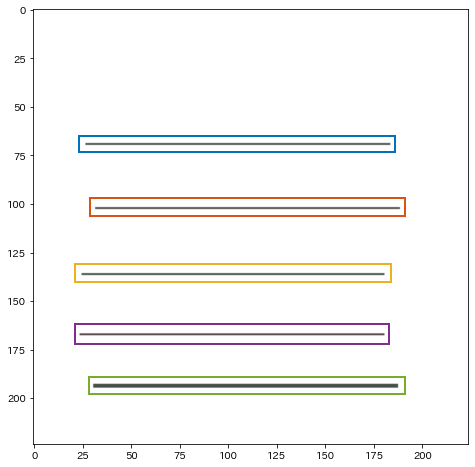

In [12]:
#N = np.random.choice(train_dataset.__len__())
#img, target = train_dataset.__getitem__(N)
N = np.random.choice(test_dataset.__len__())
img, target = test_dataset.__getitem__(N)
plot_pilimg_and_bbox(img.permute(1,2,0).detach().numpy(), target['boxes'])
print(f'N:{N} target:{target}')

## 2.5. PyTorch 用データセットの作成

In [25]:
torch.manual_seed(42)
# 学習・検証用データローダの定義 # define training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           #batch_size=2,
                                           batch_size=4, 
                                           shuffle=True, 
                                           num_workers=0,
                                           collate_fn=utils.collate_fn)

test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=4, 
                                          shuffle=False, 
                                          num_workers=0,
                                          collate_fn=utils.collate_fn)

print(f'len(train_dataset):{len(train_dataset)}, len(test_dataset):{len(test_dataset)}')

len(train_dataset):30, len(test_dataset):15


# 3. モデルの定義


## 3.1 訓練済モデルの取得関数を定義

In [26]:
def get_object_detection_model(num_classes):

    # MS-COCO で事前に学習させたモデルを読み込み
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    #model = torchvision.models.mobilenet_v2(pretrained=True)
    
    #model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
    #model = torchvision.models.detection.ssd300_vgg16(pretrained=True)
    #retinanet_model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
    #print(retinanet_model.head)

    #ssdlite_model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)
    #print(ssdlite_model.head.classification_head)
    #print(ssdlite_model.head.regression_head)

    # 分類器の入力特徴数の取得
    #print(model.roi_heads) 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    print(f'変換前 model.roi_heads:{model.roi_heads}')

    # 事前学習済頭部を新しいものに置き換え
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    print(f'変換後 model.roi_heads:{model.roi_heads}')

    return model

# 自作ヘルパー関数を使ってモデルの宣言
num_classes = len(bit.symbols)
model = get_object_detection_model(num_classes)
print(f'num_classes:{num_classes}, bit.symbols:{bit.symbols}')
#print(f'model:{model}')

#model = torchvision.models.mobilenet_v2(pretrained=True)    
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

#[(name, param.size()) for name, param in model.named_parameters()]
model.roi_heads

変換前 model.roi_heads:RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)
変換後 model.roi_heads:RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=49, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=196, bias=True)
  )
)
num_classes:49, bit.sy

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)

# 7. 訓練 <!-- # Training-->

訓練用のモデルを準備
<!-- Let's prepare the model for training -->

In [27]:
import time
import datetime
from collections import defaultdict
from collections import deque

def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """Warning: does not synchronize the deque!"""
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f'{header} Total time:{total_time_str} ({total_time/len(iterable):.3f} s/it)')


import torch
import torch.distributed as dist              

def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()

              
def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict              

In [28]:
from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
#import utils
import math

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter=": ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.4f}'))
    header = f'Epoch:[{epoch}]'

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        _images = list(image.to(device) for image in images)
        _targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(_images, _targets)
        losses = sum(_loss for _loss in loss_dict.values())

        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())
        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"損失値: {loss_value:.3f}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types

@torch.no_grad()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = 'Test:'

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator


In [29]:
# 可能なら GPU 上で学習させる
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = len(bit.symbols)

# 自作ヘルパー関数を使ってモデルを取得
model = get_object_detection_model(num_classes)

# モデルを正しいデバイスへ移動
model.to(device)

# 最適化関数の構成と設定  # construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.001)

# そして 3 エポックごとに学習率を 10 倍ずつ下げる学習率スケジューラ
# and a learning rate scheduler which decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

変換前 model.roi_heads:RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)
変換後 model.roi_heads:RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=49, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=196, bias=True)
  )
)


In [30]:
# 10 エポック分訓練 # training for 10 epochs
#num_epochs = 10
num_epochs = 1
for epoch in range(num_epochs):
    print(f'エポック:{epoch+1}')

    model.train()
    for images, targets in tqdm(train_loader):
        
        _images = list(image.to(device) for image in images)
        _targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #print(f'_targets:{_targets}')
        loss = model(_images, _targets)
        #loss = model(images, targets)
    
    # 学習率の更新
    lr_scheduler.step()

    #テストデータセットで評価
    evaluate(model, test_loader, device=device)


エポック:1


  0%|          | 0/8 [00:00<?, ?it/s]

RuntimeError: ignored

# 9. モデルの検証 <!-- # Testing our Model -->

In [ ]:
# 検証セットから画像を 1 枚選ぶ
N = np.random.choice(len(test_dataset))
img, target = test_dataset[N]

model.eval() # モデルを評価モードにする
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print(f'予測 {N:2d} バウンディングボックス数:{len(prediction["labels"])}')
print(f'実際のバウンディングボックス数    :{len(target["labels"])}')

プロットして，何が予測されたかをチェック

In [ ]:
plot_img_bbox(torch_to_pil(img), target, title='グランドトルース')


In [ ]:
plot_img_bbox(torch_to_pil(img), prediction, title='モデル予測')

このモデルは，すべてのリンゴについて多くのバウンディングボックスを予測していることがわかります。
これに nms を適用し，最終的な出力を見てみましょう。
<!-- You can see that our model predicts a lot of bounding boxes for every apple. Lets apply nms to it and see the final output -->

In [ ]:
# この関数は，元の予測値と iou の閾値を受け取ります
def apply_nms(orig_prediction, iou_thresh=0.3):
    # torchvision は保持すべき bbox のインデックスを返します。
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    return final_prediction

def torch_to_pil(img):
    """torchtensor を PIL 画像に変換する関数"""
    return torchtrans.ToPILImage()(img).convert('RGB')

In [ ]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

では，テストセットから画像を取り出し，予測してみましょう。
<!-- Now lets take an image from the test set and try to predict on it -->

In [ ]:
test_dataset = FruitImagesDataset(test_dir, 480, 480, transforms= get_transform(train=True))

# テストセットから画像を 1 枚選ぶ
# pick one image from the test set
#img, target = test_dataset[10]
img, target = test_dataset[np.random.choice(len(test_dataset))]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
#print('期待される出力\n')
# print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target, title="グランドトルース")

#print('モデルの出力\n')
# print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction, title="モデル予測")

このモデルは，単一物体の画像ではよくできています。
<!-- The model does well on single object images.-->

モデルはスライスも予測していることがわかりますが，これは失敗を意味します☹️ 。
しかし心配しないでください。
これは単なる基本的なモデルであり，我々がそれを改善できるいくつかのアイデアがあります:
<!-- You can see that our model predicts the slices too and that means a failure ☹️ . But fear not, this is just a base line model here are some ideas we can improve it -  -->

1. より良いモデルを使用する。
現在使用しているモデルのバックボーンである `resnet50` を変更し，微調整を行うことが可能です。
2. 画像の大きさ，最適化関数，学習速度のスケジュールなどの学習設定を変更することができる。
3. データ拡張を追加することができる。
ここでは，データ拡張関数の豊富なライブラリを持つ Albumentations ライブラリを使用しました。
自由に探索し，試してみてください。

<!-- 1. Use a better model. 
   We have the option of changing the backbone of our model which at present is `resnet 50` and the fine tune it.
2. We can change the training configurations like size of the images, optimizers and learning rate schedule.
3. We can add more augmentations.
   We have used the Albumentations library which has an extensive library of data augmentation functions. Feel free to explore and try them out.  -->

# 10. 結果の保存

In [ ]:
torch.save({'model': model.state_dict(),
            'optim': optimizer.state_dict()
           }, '2022_0318fine_tune_fruit.cpt')